In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import svm, cross_validation
import pylab as pl
from PIL import Image
import numpy as np

In [2]:
import os
import skimage
import skimage.io
import time

start_time = time.time()
training_set = {}
data = []
target = []
container_path = 'labeled_img_selected_bh_vs_fh/'

folders = [f for f in sorted(os.listdir(container_path)) if os.path.isdir(os.path.join(container_path, f))]
print 'folders: ', folders
for folder in folders:
    folder_path = os.path.join(container_path, folder)
    documents = [os.path.join(folder_path, d) for d in sorted(os.listdir(folder_path))]
    for pic in documents:
        if not pic.endswith('png'):
            continue
        img = skimage.img_as_float(skimage.io.imread(pic)).astype(np.float32)
        #pil_im = Image.open(pic, 'r')
        if len(data) == 0:
            print 'image shape: ', img.shape
            #plt.imshow(np.asarray(pil_im))
        #data.append(np.asarray(pil_im).ravel())
        data.append(img)
        target.append(folder)
training_set['data']=data
training_set['target']=target
print 'Total time loading training data: ', time.time()-start_time, ' seconds'

folders:  ['cls_backhand_selected', 'cls_forehand_selected']
image shape:  (600, 600, 3)
Total time loading training data:  101.984673977  seconds


In [3]:
# Make sure that caffe is on the python path:
caffe_root = '/u/zexuan/caffe/caffe/'  # this file is expected to be in {caffe_root}/examples
caffe_real_root = '/pkgs/caffe/'
thesis_root = '/ais/gobi2/pingpong/thesis/'
#!ls /pkgs/caffe
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

if not os.path.isfile('~/caffe/caffe/models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print("Downloading pre-trained CaffeNet model...")
    !~/caffe/caffe/scripts/download_model_binary.py ~/caffe/caffe/models/bvlc_reference_caffenet

Model already exists.


In [4]:
# MODEL_FILE = caffe_root +'models/bvlc_reference_caffenet/deploy.prototxt'
# PRETRAINED = caffe_root +'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
# caffe.set_mode_cpu()
# net = caffe.Classifier(MODEL_FILE, PRETRAINED,
#                        mean=np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1),
#                        channel_swap=(2,1,0),
#                        raw_scale=255,
#                        image_dims=(600, 600))
# print net.blobs['data'].data.shape
# [(k, v.data.shape) for k, v in net.blobs.items()]


# caffe.set_mode_cpu()
print caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
#!ls caffe_root+'models/bvlc_reference_caffenet/deploy.prototxt'
net = caffe.Net(caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt',
                caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel',
                caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB
print net.blobs['data'].data.shape
[(k, v.data.shape) for k, v in net.blobs.items()]

/u/zexuan/caffe/caffe/models/bvlc_reference_caffenet/deploy.prototxt
(10, 3, 227, 227)


[('data', (10, 3, 227, 227)),
 ('conv1', (10, 96, 55, 55)),
 ('pool1', (10, 96, 27, 27)),
 ('norm1', (10, 96, 27, 27)),
 ('conv2', (10, 256, 27, 27)),
 ('pool2', (10, 256, 13, 13)),
 ('norm2', (10, 256, 13, 13)),
 ('conv3', (10, 384, 13, 13)),
 ('conv4', (10, 384, 13, 13)),
 ('conv5', (10, 256, 13, 13)),
 ('pool5', (10, 256, 6, 6)),
 ('fc6', (10, 4096)),
 ('fc7', (10, 4096)),
 ('fc8', (10, 1000)),
 ('prob', (10, 1000))]

In [5]:
print 'number of images: ', len(training_set['data'])
print 'dimensionality of each image: ', training_set['data'][0].shape
traning_set_size = len(training_set['data'])

number of images:  3920
dimensionality of each image:  (600, 600, 3)


Number of input to SVM:  392 Size of each input (4096,)
Total time for neural net:  659.753025055  seconds
(227, 227, 3)
Sample image from the training set


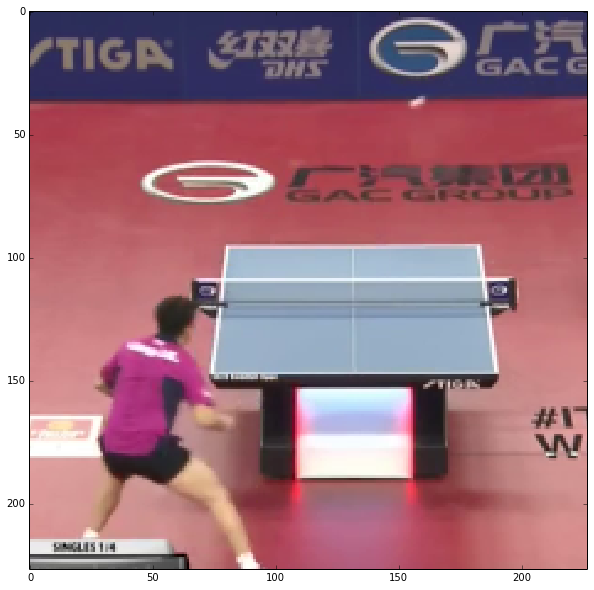

In [6]:
# print caffe.io.load_image(thesis_root + 'labeled_image_selected/bottom_player_winning_selected/point_00001_frame_00033.png').shape
# print caffe.io.load_image(thesis_root + 'labeled_image_selected/bottom_player_winning_selected/point_00001_frame_00033.png')[0][0]
# print training_set['data'][0][0][0]
start_time = time.time()

result = []
#for i in xrange(2200, 2300,10):
for i in xrange(0, traning_set_size, 10):
    #net.blobs['data'].data[...] = transformer.preprocess('data', training_set['data'][0])
    net.blobs['data'].data[...] = map(lambda x: transformer.preprocess('data', x), training_set['data'][i:i+10])
    out = net.forward()
    #print net.blobs['fc7'].data.shape
    result.append(np.mean(net.blobs['fc7'].data, axis=0))

print 'Number of input to SVM: ', len(result), 'Size of each input', result[0].shape

print 'Total time for neural net: ', time.time()-start_time, ' seconds'
print transformer.deprocess('data', net.blobs['data'].data[0]).shape
print 'Sample image from the training set'
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[4]))

In [7]:
from sklearn import decomposition

X_train, X_test, y_train, y_test = cross_validation.train_test_split(result, training_set['target'][0:4800:10], test_size=0.25, random_state=42)
#X_train, X_test, y_train, y_test = cross_validation.train_test_split(result, training_set['target'][2200:2300:10], test_size=0.3, random_state=42)

print 'X_train & y_train shapes: ', X_train.shape, y_train.shape

X_train & y_train shapes:  (294, 4096) (294,)


In [8]:
for c in [0.00001, 0.001, 0.005, 0.01, 0.05, 0.1, 1, 10, 100, 1000]:
    svc = svm.SVC(kernel='linear', C=c) 
    kfold = cross_validation.KFold(len(X_train), n_folds=4, shuffle=False)
    cv_result = cross_validation.cross_val_score(svc, X_train, y_train, cv=kfold, n_jobs=1)
    print 'C = %g, Cross validation: %s'%(c, cv_result)
    print 'C = %g, Mean value: %g'%(c, np.mean(cv_result))

C = 1e-05, Cross validation: [ 0.68918919  0.75675676  0.69863014  0.68493151]
C = 1e-05, Mean value: 0.707377
C = 0.001, Cross validation: [ 0.74324324  0.83783784  0.75342466  0.73972603]
C = 0.001, Mean value: 0.768558
C = 0.005, Cross validation: [ 0.78378378  0.83783784  0.78082192  0.75342466]
C = 0.005, Mean value: 0.788967
C = 0.01, Cross validation: [ 0.7972973   0.86486486  0.78082192  0.71232877]
C = 0.01, Mean value: 0.788828
C = 0.05, Cross validation: [ 0.77027027  0.7972973   0.7260274   0.63013699]
C = 0.05, Mean value: 0.730933
C = 0.1, Cross validation: [ 0.77027027  0.7972973   0.7260274   0.63013699]
C = 0.1, Mean value: 0.730933
C = 1, Cross validation: [ 0.77027027  0.7972973   0.7260274   0.63013699]
C = 1, Mean value: 0.730933
C = 10, Cross validation: [ 0.77027027  0.7972973   0.7260274   0.63013699]
C = 10, Mean value: 0.730933
C = 100, Cross validation: [ 0.77027027  0.7972973   0.7260274   0.63013699]
C = 100, Mean value: 0.730933
C = 1000, Cross validation:

In [9]:
for c in [0.001, 0.005, 0.01, 0.05, 0.1, 1, 2.5, 5, 7.5, 10, 50, 100, 1000, 10000]:
    svc = svm.SVC(C=c, kernel='rbf')
    kfold = cross_validation.KFold(len(X_train), n_folds=4, shuffle=False)
    cv_result = cross_validation.cross_val_score(svc, X_train, y_train, cv=kfold, n_jobs=1)
    print 'C = %g, Cross validation: %s'%(c, cv_result)
    print 'C = %g, Mean value: %g'%(c, np.mean(cv_result))

C = 0.001, Cross validation: [ 0.68918919  0.75675676  0.69863014  0.68493151]
C = 0.001, Mean value: 0.707377
C = 0.005, Cross validation: [ 0.68918919  0.75675676  0.69863014  0.68493151]
C = 0.005, Mean value: 0.707377
C = 0.01, Cross validation: [ 0.68918919  0.75675676  0.69863014  0.68493151]
C = 0.01, Mean value: 0.707377
C = 0.05, Cross validation: [ 0.68918919  0.75675676  0.69863014  0.68493151]
C = 0.05, Mean value: 0.707377
C = 0.1, Cross validation: [ 0.68918919  0.75675676  0.69863014  0.68493151]
C = 0.1, Mean value: 0.707377
C = 1, Cross validation: [ 0.68918919  0.75675676  0.69863014  0.68493151]
C = 1, Mean value: 0.707377
C = 2.5, Cross validation: [ 0.75675676  0.83783784  0.73972603  0.7260274 ]
C = 2.5, Mean value: 0.765087
C = 5, Cross validation: [ 0.77027027  0.85135135  0.78082192  0.75342466]
C = 5, Mean value: 0.788967
C = 7.5, Cross validation: [ 0.78378378  0.85135135  0.79452055  0.75342466]
C = 7.5, Mean value: 0.79577
C = 10, Cross validation: [ 0.7972

In [10]:
for c in [0.01, 0.05, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]:
    svc = svm.SVC(C=c, kernel='poly', degree=2)
    kfold = cross_validation.KFold(len(X_train), n_folds=4, shuffle=False)
    cv_result = cross_validation.cross_val_score(svc, X_train, y_train, cv=kfold, n_jobs=1)
    print 'C = %g, Cross validation: %s'%(c, cv_result)
    print 'C = %g, Mean value: %g'%(c, np.mean(cv_result))

C = 0.01, Cross validation: [ 0.68918919  0.75675676  0.69863014  0.68493151]
C = 0.01, Mean value: 0.707377
C = 0.05, Cross validation: [ 0.68918919  0.75675676  0.69863014  0.68493151]
C = 0.05, Mean value: 0.707377
C = 0.1, Cross validation: [ 0.68918919  0.75675676  0.69863014  0.68493151]
C = 0.1, Mean value: 0.707377
C = 1, Cross validation: [ 0.71621622  0.7972973   0.69863014  0.68493151]
C = 1, Mean value: 0.724269
C = 10, Cross validation: [ 0.7972973   0.82432432  0.78082192  0.73972603]
C = 10, Mean value: 0.785542
C = 100, Cross validation: [ 0.81081081  0.82432432  0.75342466  0.63013699]
C = 100, Mean value: 0.754674
C = 1000, Cross validation: [ 0.81081081  0.82432432  0.75342466  0.63013699]
C = 1000, Mean value: 0.754674
C = 10000, Cross validation: [ 0.81081081  0.82432432  0.75342466  0.63013699]
C = 10000, Mean value: 0.754674
C = 100000, Cross validation: [ 0.81081081  0.82432432  0.75342466  0.63013699]
C = 100000, Mean value: 0.754674
C = 1e+06, Cross validation

In [11]:
for c in [0.01, 0.05, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]:
    svc = svm.SVC(C=c, kernel='poly', degree=3)
    kfold = cross_validation.KFold(len(X_train), n_folds=4, shuffle=False)
    cv_result = cross_validation.cross_val_score(svc, X_train, y_train, cv=kfold, n_jobs=1)
    print 'C = %g, Cross validation: %s'%(c, cv_result)
    print 'C = %g, Mean value: %g'%(c, np.mean(cv_result))

C = 0.01, Cross validation: [ 0.68918919  0.75675676  0.69863014  0.68493151]
C = 0.01, Mean value: 0.707377
C = 0.05, Cross validation: [ 0.68918919  0.75675676  0.69863014  0.68493151]
C = 0.05, Mean value: 0.707377
C = 0.1, Cross validation: [ 0.68918919  0.75675676  0.69863014  0.68493151]
C = 0.1, Mean value: 0.707377
C = 1, Cross validation: [ 0.72972973  0.81081081  0.75342466  0.7260274 ]
C = 1, Mean value: 0.754998
C = 10, Cross validation: [ 0.81081081  0.86486486  0.80821918  0.7260274 ]
C = 10, Mean value: 0.802481
C = 100, Cross validation: [ 0.78378378  0.83783784  0.75342466  0.67123288]
C = 100, Mean value: 0.76157
C = 1000, Cross validation: [ 0.78378378  0.83783784  0.75342466  0.67123288]
C = 1000, Mean value: 0.76157
C = 10000, Cross validation: [ 0.78378378  0.83783784  0.75342466  0.67123288]
C = 10000, Mean value: 0.76157
C = 100000, Cross validation: [ 0.78378378  0.83783784  0.75342466  0.67123288]
C = 100000, Mean value: 0.76157
C = 1e+06, Cross validation: [ 

In [12]:
svc = svm.SVC(kernel='precomputed')
kernel_train = np.dot(X_train, X_train.T)  # linear kernel
svc.fit(kernel_train, y_train)

# Testing
from sklearn.metrics import accuracy_score
kernel_test = np.dot(X_test, X_train.T)
y_pred = svc.predict(kernel_test)
print accuracy_score(y_test, y_pred)

0.775510204082


In [13]:
clf = svm.SVC(kernel='poly', C=10, degree=3).fit(X_train, y_train)
clf.score(X_test, y_test)

0.77551020408163263

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
clf = neigh.fit(X_train, y_train)
clf.score(X_test, y_test)